# Assignmnet 5: Visualizing Data Veracity Challenges in Multi-Label Classification

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.manifold import Isomap

In [24]:
file_path = 'yeast.csv'

df = pd.read_csv(file_path, header=None)

X = df.iloc[:, :-14]
y = df.iloc[:, -14:]

print(f"Shape of features (X): {X.shape}") 
print(f"Shape of labels (y): {y.shape}")

# Assign names to label columns
label_cols = [f"class_{i}" for i in range(y.shape[1])]
y.columns = label_cols

Shape of features (X): (2417, 103)
Shape of labels (y): (2417, 14)


No. of features = 103

No. of classes = 14

No. of data points = 2417

In [25]:

# --- Check for missing, infinite, or blank values ---
print("Checking dataset\n")

# 1Check for NaN (missing) values
nan_check = df.isna().sum().sum()
print(f"Number of NaN values: {nan_check}")

# 2Check for infinite values
inf_check = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"Number of infinite values: {inf_check}")

# 3Check for blank (empty string) values
blank_check = (df.astype(str).apply(lambda x: x.str.strip()) == "").sum().sum()
print(f"Number of blank ('') values: {blank_check}")

# 4Summary message
if nan_check == 0 and inf_check == 0 and blank_check == 0:
    print("\n No NaN, inf, or blank values found in the dataset.")
else:
    print("\n Data contains invalid entries — cleaning recommended.")


Checking dataset

Number of NaN values: 0
Number of infinite values: 0
Number of blank ('') values: 0

 No NaN, inf, or blank values found in the dataset.


In [26]:
y_lists = y.apply(lambda row: [cls for cls in label_cols if row[cls] == 1], axis=1)

# Step 2: Find top 2 single-label classes
single_label_rows = y_lists[y_lists.map(len) == 1]
single_labels = single_label_rows.map(lambda x: x[0])
top2_single = single_labels.value_counts().nlargest(2).index.tolist()

# Step 3: Find most frequent multi-label combination
multi_label_rows = y_lists[y_lists.map(len) > 1].map(tuple)  # hashable
top_multi = multi_label_rows.value_counts().idxmax()

# Step 4: Remap target
def remap_labels(labels):
    if len(labels) == 1 and labels[0] in top2_single:
        return labels[0]
    elif tuple(labels) == top_multi:
        return "_".join(top_multi)  # stringify combination
    else:
        return "Other"

df["new_target"] = y_lists.map(remap_labels)

mapping = {
    "class_0": "single_first",
    "Other": "other",
    "class_2_class_3_class_11_class_12": "multi"
}

df["new_target"] = df["new_target"].replace(mapping)

print("Top 2 single-label classes:", top2_single)
print("Most frequent multi-label combo:", top_multi)
print(df["new_target"].value_counts())

y_new_target = df.iloc[:,-1]

print(y_new_target.unique())

Top 2 single-label classes: ['class_0']
Most frequent multi-label combo: ('class_2', 'class_3', 'class_11', 'class_12')
new_target
other           2148
multi            237
single_first      32
Name: count, dtype: int64
['other' 'multi' 'single_first']


## Label Selection for Visualization

Since the yeast dataset contains **14 possible class labels**, visualizing all combinations would result in a cluttered and confusing plot.  
To simplify the visualization, we selected:

- The **most frequent single-label class** → `class_0`
- The **most frequent multi-label combination** → (`class_2`, `class_3`, `class_11`, `class_12`)
- All other samples were grouped into an **"Other"** category.
- There was no second frequent single label class.

This produced a **simplified categorical target** with only three distinct groups:
- `single_first` → represents the dominant single-label class (`class_0`)
- `multi` → represents the most common multi-label combination
- `other` → all remaining label combinations

| Category       | Count | Description |
|----------------|--------|-------------|
| `other`        | 2148   | All less frequent single/multi-label cases |
| `multi`        | 237    | The most frequent multi-label combination |
| `single_first` | 32     | The most frequent single-label class (`class_0`) |

### Observation
The dataset is **highly imbalanced**, with the majority of samples falling into the `"other"` category.  
Only a small number of samples belong to the `"single_first"` and `"multi"` groups.
 
--- 


## Scaling Before Distance-Based Dimensionality Reduction

The **yeast dataset** contains **103 features**, each describing various biological or physicochemical properties.  
These features exist on **different numerical scales** — for example, one feature might range from 0–1, while another might range from 0–1000.

Distance-based dimensionality reduction methods such as **t-SNE** and **Isomap** rely on **pairwise distances** (usually Euclidean distance) to determine the similarity between data points.  
If the features are not scaled, those with larger numeric ranges dominate the distance calculation, overshadowing other important but smaller-valued features.  

### Without Scaling
- Large-valued features bias the distance metric.
- The model overemphasizes some features and ignores others.
- The resulting manifold (low-dimensional representation) becomes **distorted** or **misleading**.

### With Standardization
By applying **Standardization**, each feature is transformed to have:
- Mean ≈ 0  
- Standard deviation ≈ 1  

This ensures that **all features contribute equally** to the distance metric, allowing methods like **Isomap** and **t-SNE** to correctly capture the **true structure** of the yeast data.

---

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape before scaling:", X.shape)
print("Shape after scaling:", X_scaled.shape)

Shape before scaling: (2417, 103)
Shape after scaling: (2417, 103)


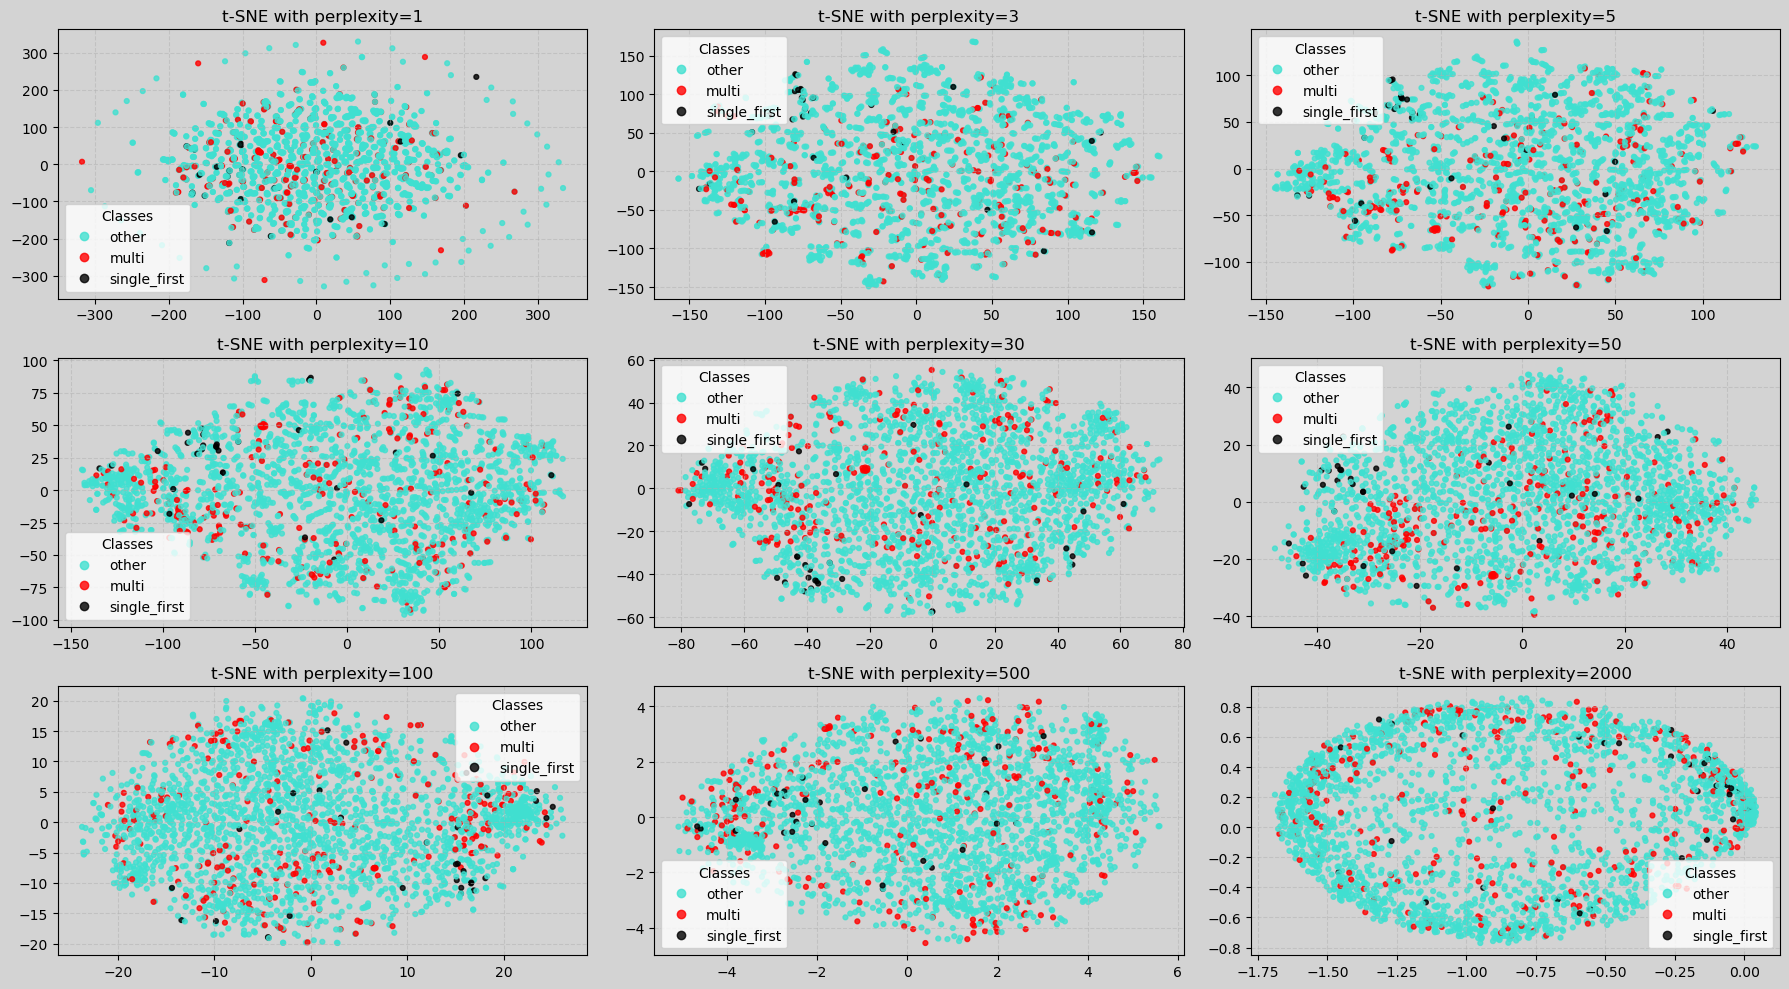

In [28]:
# Encode labels into numbers
label_to_int = {label: idx for idx, label in enumerate(y_new_target.unique())}
y_encoded = y_new_target.map(label_to_int)

# High-contrast, colorblind-friendly palette
custom_colors = ["turquoise","red", "black"]

perplexities = [1, 3, 5, 10, 30, 50, 100, 500, 2000]
#perplexities = [200]

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()  # flatten into 1D array

fig.patch.set_facecolor("lightgrey")

for i, p in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, max_iter=5000)
    X_embedded = tsne.fit_transform(X_scaled)
    
    scatter = axes[i].scatter(
        X_embedded[:, 0], X_embedded[:, 1], 
        c=y_encoded, s=12, alpha=0.8,
        cmap=ListedColormap(custom_colors)
    )
    axes[i].set_title(f"t-SNE with perplexity={p}")
    axes[i].set_facecolor("lightgrey") 
    axes[i].grid(True, linestyle="--", alpha=0.5)
    handles, _ = scatter.legend_elements()
    axes[i].legend(handles, label_to_int.keys(), title="Classes")

#plt.title("t-SNE with different peplexity parameters")
plt.tight_layout()
plt.show()


### t-SNE Implementation and Perplexity Choice

The t-SNE algorithm was applied to the scaled feature matrix to reduce its dimensionality to two components for visualization. The `perplexity` hyperparameter, which loosely corresponds to the number of effective nearest neighbors for each point, was tuned to find the optimal representation of the data's underlying structure.


### Analysis of Perplexity Values:

* **Low Perplexity (1, 3, 5, 10):** At very low perplexity values, the visualization focuses excessively on the **local structure**. This results in a "shattered" or "stringy" appearance where global patterns are lost. The data points are broken into many small, isolated clusters, which doesn't provide a useful overview of the relationships between the major classes.
* **High Perplexity (100, 500, 2000):** At high perplexity values, the algorithm gives too much weight to the **global structure**. This causes the distinct clusters to merge into a single, dense, and rounded cloud of points. This effect, known as "crowding," obscures the finer distinctions between subgroups within the data.
* **Balanced Perplexity (30, 50):** Perplexity values in this range provide a healthy balance between local and global aspects of the data. The plots for perplexity 30 and 50 reveal clear, well-formed clusters that are reasonably separated from one another, giving a meaningful representation of the data's topology.

### Final Choice of Perplexity: **50**

The **perplexity of 50** is chosen as the final value. This plot offers the best trade-off, revealing both the large-scale separation between the primary `other` (cyan) category and the `multi`/`single_first` categories, as well as distinct sub-clusters within the `other` group itself. The structure is coherent and doesn't suffer from the fragmentation of lower values or the crowding of higher ones.

---

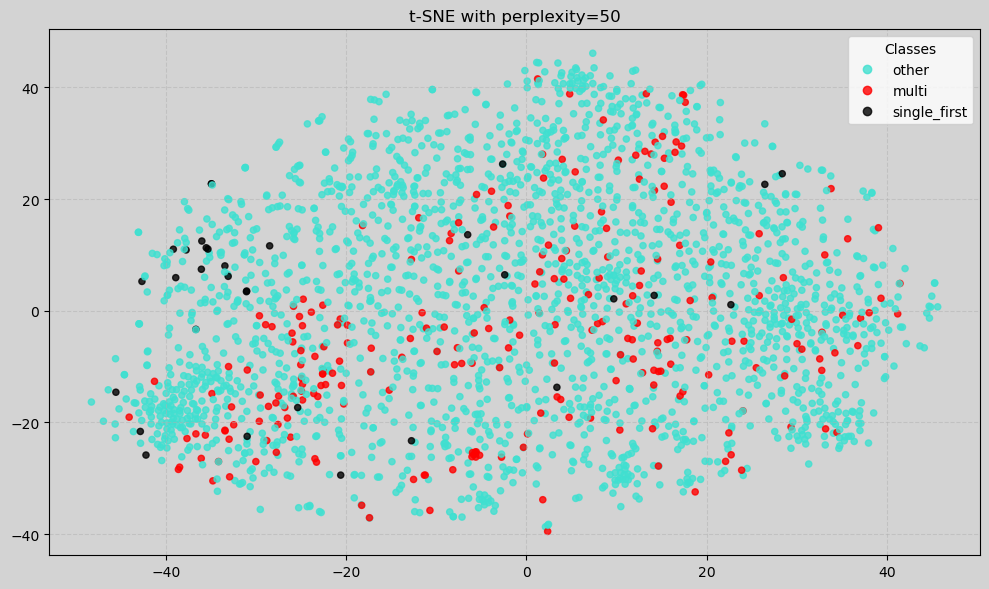

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.patch.set_facecolor("lightgrey")

# Initialize and run t-SNE
perplexity_value = 50
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42, max_iter=5000)
X_embedded = tsne.fit_transform(X_scaled)

scatter = axes.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=y_encoded, s=20, alpha=0.8, 
    cmap=ListedColormap(custom_colors)
)

axes.set_title(f"t-SNE with perplexity={perplexity_value}")
axes.set_facecolor("lightgrey") 
axes.grid(True, linestyle="--", alpha=0.5)

# Create and set the legend
handles, _ = scatter.legend_elements()
axes.legend(handles, label_to_int.keys(), title="Classes")

plt.tight_layout()
plt.show()

### Visualization

A 2D scatter plot was generated using the coordinates from the final t-SNE result (perplexity=50). Each point in the plot was colored according to its functional category: `other` (cyan), `multi` (red), and `single_first` (black). This allows for a direct visual inspection of how well the functional categories cluster in the reduced-dimensional space.


#### Noisy/Ambiguous Labels

We can identify potential noisy or ambiguous labels by looking for points that are deeply embedded within a cluster of a different color.

* In the large central cluster dominated by the **cyan** (`other`) class, there are several **red** (`multi`) and **black** (`single_first`) points scattered throughout.
* There are few **black** points in the cluster of red points on the bottom left which could be noise.

These "misplaced" points suggest that their feature profiles (e.g., expression patterns) are much more similar to the class they are embedded in than the class they are labeled as. This could be due to genuine biological ambiguity or errors during the original data labeling process.

### Outliers

Outliers appear as isolated points or tiny, distant clusters, far from the main groups.

* On the top and bottom of the plots we can see few **red** points without any close neighbours hence those can be considered as outliers.
* There is also a single **black** point scattered without any neighbours throughout the plot except to the left top. Hence those points maybe outlier.

* **Hypothesis:** In a biological context (like gene expression), these outliers might represent:
 **Rare Cell Types or States:** Unique samples with distinct expression patterns not shared by the larger groups.


### Hard-to-Learn Samples

These are samples located in regions where different colors are thoroughly mixed, making it difficult to draw a clean separation boundary.

* The primary region of difficulty is the **interface between the large cyan cluster and the main red/black cluster**. In this area, the cyan, red, and black points are heavily intermingled.

**Explanation:** A simple classifier, such as a linear model, would likely struggle in these regions because the samples from different classes are not linearly separable in this feature space. The model would have a high error rate here, as the features of a `multi` sample might be almost indistinguishable from a neighboring `other` sample. More complex, non-linear models would be required to learn the intricate decision boundary in this "mixed" zone.

---

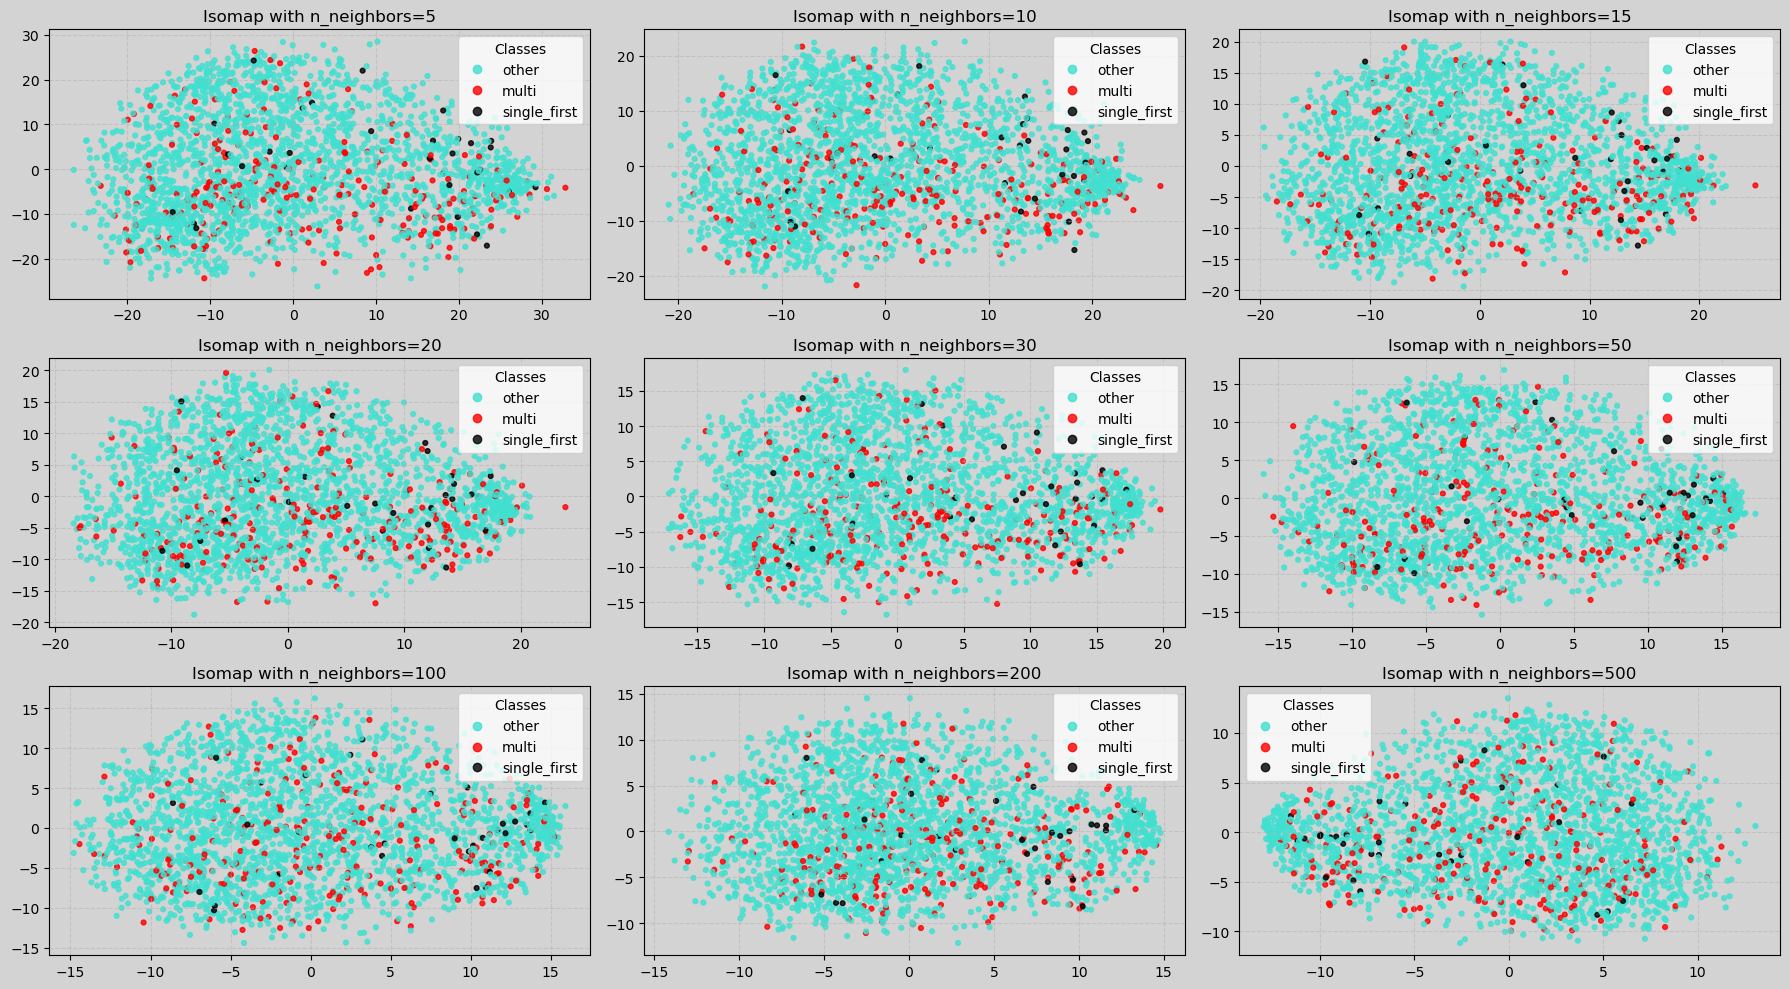

In [30]:
# Encode labels into numbers
label_to_int = {label: idx for idx, label in enumerate(y_new_target.unique())}
y_encoded = y_new_target.map(label_to_int)

# High-contrast, colorblind-friendly palette
custom_colors = ["turquoise", "red", "black"]

# Different neighborhood sizes to try
neighbors_list = [5, 10, 15, 20, 30, 50, 100, 200, 500]

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

fig.patch.set_facecolor("lightgrey")  # figure background

for i, n in enumerate(neighbors_list):
    isomap = Isomap(n_components=2, n_neighbors=n)
    X_embedded = isomap.fit_transform(X_scaled)
    
    scatter = axes[i].scatter(
        X_embedded[:, 0], X_embedded[:, 1],
        c=y_encoded, s=12, alpha=0.8,
        cmap=ListedColormap(custom_colors)
    )
    axes[i].set_title(f"Isomap with n_neighbors={n}")
    axes[i].set_facecolor("lightgrey")
    axes[i].grid(True, linestyle="--", alpha=0.5)
    
    handles, _ = scatter.legend_elements()
    axes[i].legend(handles, label_to_int.keys(), title="Classes")

plt.tight_layout()
plt.show()

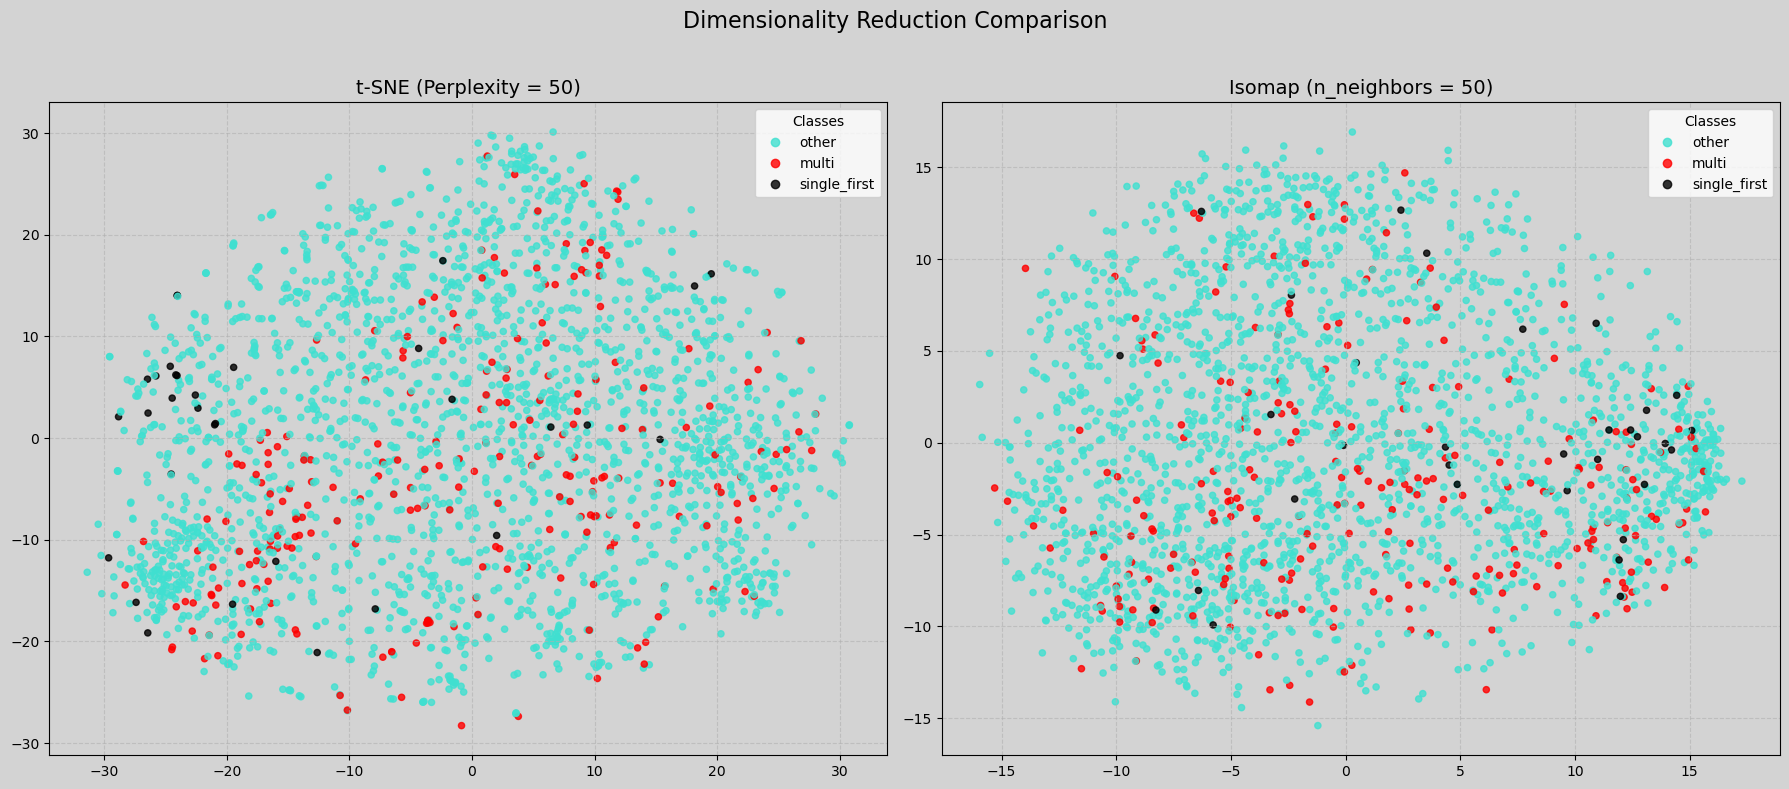

In [31]:
# Encode labels into numbers
label_to_int = {label: idx for idx, label in enumerate(y_new_target.unique())}
y_encoded = y_new_target.map(label_to_int)

custom_colors = ["turquoise", "red", "black"]
cmap = ListedColormap(custom_colors)

# Set hyperparameters
perplexity_val = 50
n_neighbors_val = 50

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.patch.set_facecolor("lightgrey")
fig.suptitle("Dimensionality Reduction Comparison", fontsize=16)

tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, max_iter=500)
X_tsne_embedded = tsne.fit_transform(X_scaled)

scatter1 = axes[0].scatter(
    X_tsne_embedded[:, 0], X_tsne_embedded[:, 1],
    c=y_encoded, s=20, alpha=0.8, cmap=cmap
)
axes[0].set_title(f"t-SNE (Perplexity = {perplexity_val})", fontsize=14)


isomap = Isomap(n_components=2, n_neighbors=n_neighbors_val)
X_isomap_embedded = isomap.fit_transform(X_scaled)

scatter2 = axes[1].scatter(
    X_isomap_embedded[:, 0], X_isomap_embedded[:, 1],
    c=y_encoded, s=20, alpha=0.8, cmap=cmap
)
axes[1].set_title(f"Isomap (n_neighbors = {n_neighbors_val})", fontsize=14)

for ax in axes:
    ax.set_facecolor("lightgrey")
    ax.grid(True, linestyle="--", alpha=0.6)
    handles, _ = ax.collections[0].legend_elements()
    ax.legend(handles, label_to_int.keys(), title="Classes")

# Display the final plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Comparison of Isomap and t-SNE

* Based on the provided visualizations, there is no clear indication on which is better at showing the reduced dataset structure. There can be no meaningful conclusion. But on just viewing we can see that t- SNE has more no of regions with high density tho it is well spread.
* In both t-SNE and Iso map the **red** and **black** points are scattered throughout with no definite structure or clusters.
* The fact that the classes are intermingled in this plot suggests that on a global scale, they are not cleanly separable and may lie along a continuous spectrum of gene expression patterns.

---

## The Data Manifold and Classification Difficulty 

#### The Concept of a Data Manifold

Think of a **data manifold** as the underlying, lower-dimensional surface on which the high-dimensional data points lie. For example, the surface of a globe is a 2D curved manifold existing within 3D space. Similarly, our high-dimensional gene expression data might naturally lie on a simpler, albeit curved, "surface." Manifold learning algorithms like Isomap try to "unroll" this surface to view its intrinsic geometry.

#### Manifold Complexity and Its Implications 

The Isomap plot gives us a glimpse into this unrolled manifold.

* **Does the plot suggest a complex manifold**
    The plot suggests a **complex, non-linear manifold**. It is not a simple, flat plane or a sphere. The data forms a single, continuous structure with some curvature, and the different classes are spread across it rather than occupying separate, distinct territories. It isn't extremely folded or tangled, but it's certainly not simple.

* **How does this relate to classification difficulty**
    The complexity of the manifold is directly related to the difficulty of classification.
    * **Easy Classification:** If the manifold were simple and the classes were located on completely separate, distant parts of it, a simple classifier could easily draw a boundary to separate them.
    * **Hard Classification:** As shown in the Isomap plot, the `other`, `multi`, and `single_first` classes are heavily **intermingled** on the manifold. This means that in the original high-dimensional space, a sample from one class can be a close neighbor to a sample from another class. A simple classifier would struggle immensely because there is no clean, simple boundary that can separate the thoroughly mixed points. The complex, overlapping nature of the classes on this manifold is a visual confirmation of why this is a challenging classification problem.